# Load rankings and categories

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json,os,pdb
import tqdm
import warnings
import yfinance as yf

# Load data


In [2]:
df = pd.read_parquet('~/work/project/daily_20221004.parquet.gzip') # modify the path according to your needs
df.columns = [c.split('.')[-1].replace('_','') for c in df.columns]
df.index = df.index.set_levels([df.index.levels[0], pd.to_datetime(df.index.levels[1])])

Load the listing file and check for the rankings

In [3]:
with open('listing_map_20221004.json',encoding='utf-8') as json_data:
    data = json.load(json_data)
listmap = pd.DataFrame(data['data'])
listmap.sort_values('cmc_rank',inplace=True)
listmap.set_index('cmc_rank',inplace=True)
listmap['symbol_id'] = listmap['symbol']+ '_'+ listmap['id'].astype(str)

In [4]:
df.head()

timeopen  \
symbol_id time_close                                                   
MPH_7742  2020-11-23 00:59:59.999000+00:00  2020-11-23T00:00:00.000Z   
          2020-11-24 00:59:59.999000+00:00  2020-11-24T00:00:00.000Z   
          2020-11-25 00:59:59.999000+00:00  2020-11-25T00:00:00.000Z   
          2020-11-26 00:59:59.999000+00:00  2020-11-26T00:00:00.000Z   
          2020-11-27 00:59:59.999000+00:00  2020-11-27T00:00:00.000Z   

                                                            timehigh  \
symbol_id time_close                                                   
MPH_7742  2020-11-23 00:59:59.999000+00:00  2020-11-23T00:00:07.000Z   
          2020-11-24 00:59:59.999000+00:00  2020-11-24T00:00:07.000Z   
          2020-11-25 00:59:59.999000+00:00  2020-11-25T00:00:06.000Z   
          2020-11-26 00:59:59.999000+00:00  2020-11-26T00:56:05.000Z   
          2020-11-27 00:59:59.999000+00:00  2020-11-27T00:57:05.000Z   

                                                             timelow  \
symbol_id time_close                                                   
MPH_7742  2020-11-23 00:59:59.999000+00:00  2020-11-23T00:37:05.000Z   
          2020-11-24 00:59:59.999000+00:00  2020-11-24T00:40:06.000Z   
          2020-11-25 00:59:59.999000+00:00  2020-11-25T00:58:05.000Z   
          2020-11-26 00:59:59.999000+00:00  2020-11-26T00:13:06.000Z   
          2020-11-27 00:59:59.999000+00:00  2020-11-27T00:16:05.000Z   

                                                 open       high        low  \
symbol_id time_close                                                          
MPH_7742  2020-11-23 00:59:59.999000+00:00  90.554933  90.554933  79.852330   
          2020-11-24 00:59:59.999000+00:00  85.161030  85.161030  80.694133   
          2020-11-25 00:59:59.999000+00:00  57.527366  57.527366  53.679986   
          2020-11-26 00:59:59.999000+00:00  39.466839  40.121814  38.980499   
          2020-11-27 00:59:59.999000+00:00  30.002092  30.391962  29.690305   

                                                close        volume  \
symbol_id time_close                                                  
MPH_7742  2020-11-23 00:59:59.999000+00:00  85.599205  1.600851e+07   
          2020-11-24 00:59:59.999000+00:00  81.645754  1.009738e+07   
          2020-11-25 00:59:59.999000+00:00  53.704963  8.899399e+06   
          2020-11-26 00:59:59.999000+00:00  40.056399  4.225065e+06   
          2020-11-27 00:59:59.999000+00:00  30.383005  2.933446e+06   

                                            marketcap  \
symbol_id time_close                                    
MPH_7742  2020-11-23 00:59:59.999000+00:00        0.0   
          2020-11-24 00:59:59.999000+00:00        0.0   
          2020-11-25 00:59:59.999000+00:00        0.0   
          2020-11-26 00:59:59.999000+00:00        0.0   
          2020-11-27 00:59:59.999000+00:00        0.0   

                                                           timestamp symbol  \
symbol_id time_close                                                          
MPH_7742  2020-11-23 00:59:59.999000+00:00  2020-11-23T00:59:59.999Z    MPH   
          2020-11-24 00:59:59.999000+00:00  2020-11-24T00:59:59.999Z    MPH   
          2020-11-25 00:59:59.999000+00:00  2020-11-25T00:59:59.999Z    MPH   
          2020-11-26 00:59:59.999000+00:00  2020-11-26T00:59:59.999Z    MPH   
          2020-11-27 00:59:59.999000+00:00  2020-11-27T00:59:59.999Z    MPH   

                                              id  
symbol_id time_close                              
MPH_7742  2020-11-23 00:59:59.999000+00:00  7742  
          2020-11-24 00:59:59.999000+00:00  7742  
          2020-11-25 00:59:59.999000+00:00  7742  
          2020-11-26 00:59:59.999000+00:00  7742  
          2020-11-27 00:59:59.999000+00:00  7742

# Begining Analysis

In [5]:
df2 = df.copy() # makes copy of original df
df2.reset_index(inplace = True)
df2['year'] = pd.DatetimeIndex(df2['timeopen']).year # adds year column to data frame
df2['month'] = pd.DatetimeIndex(df2['timeopen']).month  # adds month column to data frame
df2['day'] = pd.DatetimeIndex(df2['timeopen']).day  # adds day column to data frame
df2_first = df2.drop_duplicates(subset='symbol_id') #finds the first entry for each symbol
df2_last = df2.drop_duplicates(subset='symbol_id', keep='last').copy() #finds the last symbol for each symbol
df2_last['market_perc'] = df2_last['marketcap']/ df2_last['marketcap'].sum() # finds the market cap percentage. Used last known marketcap to calc
df2_last = df2_last.sort_values('market_perc', ascending=False) # sort from highest market cap percent to lowest
df2_last['cum_perc'] = df2_last['market_perc'].cumsum() # creates a column for the cumulative percentage

In [6]:
df2_last.head(10) #shows the top 10 highest market cap coins

,symbol_id,time_close,timeopen,timehigh,timelow,open,high,low,close,volume,marketcap,timestamp,symbol,id,year,month,day,market_perc,cum_perc
1010930,BTC_1,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:20:00.000Z,2022-10-04T00:59:00.000Z,19623.584689,19682.097005,19569.057599,19569.057599,3.019521e+10,3.751072e+11,2022-10-04T00:59:59.999Z,BTC,1,2022,10,4,0.359519,0.359519
1140492,ETH_1027,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:17:00.000Z,2022-10-04T00:59:00.000Z,1323.278296,1327.501947,1321.478301,1321.478301,9.889020e+09,1.620678e+11,2022-10-04T00:59:59.999Z,ETH,1027,2022,10,4,0.155333,0.514852
1217597,USDT_825,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:39:00.000Z,2022-10-04T00:10:00.000Z,1.000091,1.000136,1.000065,1.000099,3.948120e+10,6.795617e+10,2022-10-04T00:59:59.999Z,USDT,825,2022,10,4,0.065132,0.579984
224969,USDC_3408,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:21:00.000Z,2022-10-04T00:05:00.000Z,0.999916,1.000129,0.999848,0.999932,4.347674e+09,4.717649e+10,2022-10-04T00:59:59.999Z,USDC,3408,2022,10,4,0.045216,0.625200
591885,BNB_1839,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:17:00.000Z,2022-10-04T00:59:00.000Z,287.024182,287.688765,286.528964,286.528964,6.934432e+08,4.622780e+10,2022-10-04T00:59:59.999Z,BNB,1839,2022,10,4,0.044307,0.669506
57598,LUNA_4172,2022-04-18 00:59:59.999000+00:00,2022-04-18T00:00:00.000Z,2022-04-18T00:59:00.000Z,2022-04-18T00:10:00.000Z,77.445059,78.015995,77.039673,78.015995,1.134889e+09,2.781884e+10,2022-04-18T00:59:59.999Z,LUNA,4172,2022,4,18,0.026663,0.696169
664711,XRP_52,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:00:00.000Z,2022-10-04T00:58:00.000Z,0.462878,0.462878,0.456886,0.456954,1.828199e+09,2.280231e+10,2022-10-04T00:59:59.999Z,XRP,52,2022,10,4,0.021855,0.718024
935969,BUSD_4687,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:15:00.000Z,2022-10-04T00:40:00.000Z,1.000200,1.000815,0.999495,1.000401,6.356159e+09,2.105067e+10,2022-10-04T00:59:59.999Z,BUSD,4687,2022,10,4,0.020176,0.738200
831362,UST_7129,2022-04-18 00:59:59.999000+00:00,2022-04-18T00:00:00.000Z,2022-04-18T00:56:00.000Z,2022-04-18T00:03:00.000Z,1.001566,1.001987,1.001280,1.001743,2.391945e+08,1.747529e+10,2022-04-18T00:59:59.999Z,UST,7129,2022,4,18,0.016749,0.754949
350442,ADA_2010,2022-10-04 00:59:59.999000+00:00,2022-10-04T00:00:00.000Z,2022-10-04T00:17:00.000Z,2022-10-04T00:59:00.000Z,0.428003,0.428976,0.426254,0.426254,4.408164e+08,1.460054e+10,2022-10-04T00:59:59.999Z,ADA,2010,2022,10,4,0.013994,0.768942


In [7]:
df_cutoff = df2_last.loc[df2_last['cum_perc'] <= .91]
tethers = df_cutoff.loc[(df_cutoff['close'] > .99) & (df_cutoff['close'] < 1.01)]['symbol_id'].values # removes 4 tether coins
df_cutoff = df_cutoff.loc[~df_cutoff['symbol_id'].isin(tethers)]
df2_cutoff = df2_first.loc[df2_first['symbol_id'].isin(df_cutoff['symbol_id'])]
symbols = df2_cutoff.loc[df2_cutoff['year'] > 2020]['symbol_id'].values
symbols2 = df2_cutoff.loc[(df2_cutoff['year'] == 2020) & (df2_cutoff['month'] > 8)]['symbol_id'].values
all_symbols = np.concatenate((symbols, symbols2))

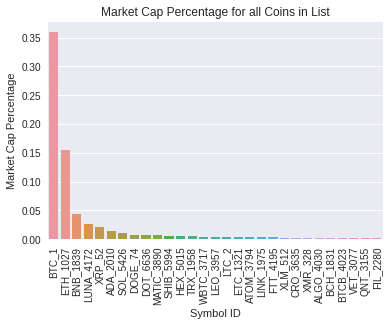

In [8]:
plt.figure(1)
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 15]
sns.barplot(data=df_cutoff.loc[~df_cutoff['symbol_id'].isin(all_symbols)], x="symbol_id", y="market_perc")
plt.xlabel('Symbol ID')
plt.ylabel('Market Cap Percentage')
plt.title('Market Cap Percentage for all Coins in List')
plt.xticks(rotation=90)
plt.show()

In [9]:
print(len(df2_cutoff))

40


In [10]:
print(len(all_symbols))

11


In [11]:
df3 = df.copy()
df3.reset_index(inplace = True)
df3 = df3.loc[df3['symbol_id'].isin(df_cutoff['symbol_id'])]
df3 = df3.loc[~df3['symbol_id'].isin(all_symbols)]

In [12]:
df3['month'] = df3['time_close'].dt.month
df3['day'] = df3['time_close'].dt.day
df3['weekday'] = df3['time_close'].dt.weekday
df3['day of week'] = np.where(df3['weekday'] > 4, 0, 1)

In [13]:
df3['time_close'] = df3['time_close'].dt.date
df3 = df3[(df3['time_close'] >= df3.loc[df3['symbol_id'] == 'DOT_6636']['time_close'].min())]
df3.dropna(subset='volume', inplace=True)
df3 = df3[(df3['time_close'] >= df3['time_close'].min())]
all_syms = df3['symbol_id'].unique()

In [14]:
df3['price change'] = df3['close'].pct_change()
df3['volume change'] = df3['volume'].pct_change()
df3['tomorrow change'] = df3['close'].pct_change().shift(-1)

df3.drop(df3.groupby('symbol_id')['price change'].head(1).index, inplace=True)
df3.drop(df3.groupby('symbol_id')['tomorrow change'].tail(1).index, inplace=True) 

In [15]:
def get_info(tick):
    TICKER = tick
    START_DATE = '2020-09-23'
    END_DATE = '2022-10-4'
    stock = yf.download(TICKER, 
                     start=START_DATE, 
                     end=END_DATE,
                     progress=False)
    df3[tick] = stock['Adj Close']
    df3[tick] = df3.groupby(['symbol_id'])[tick].ffill()

In [16]:
df3.set_index(['time_close'],inplace = True)
ticks = ['SPY', '^VIX', '^TNX', 'GC=F', 'CL=F', 'EURUSD=X']
for tick in ticks:
    get_info(tick)
df3 = df3.rename(columns={'^TNX': '10Y Treasury',
                          '^VIX': 'VIX',
                          'GC=F': 'Gold',
                          'CL=F': 'Oil',
                          'EURUSD=X': 'EUR_USD'})

In [17]:
df3.drop(columns=['timeopen', 'timehigh', 'timelow', 'open', 'high', 'low', 'timestamp', 'symbol', 'id'], inplace = True)
df3.reset_index(inplace = True)
df3.set_index(['symbol_id', 'time_close'],inplace = True)

## Got rid of all nan volumes, first and last entries for each coin. Starts at 2020-09-24 ends at 2022-10-3

In [18]:
df3.head()

close        volume     marketcap  month  day  \
symbol_id time_close                                                     
LUNA_4172 2020-09-24  0.290884  2.125867e+06  1.122608e+08      9   24   
          2020-09-25  0.296397  3.619720e+06  1.143941e+08      9   25   
          2020-09-26  0.316665  9.678458e+06  1.222604e+08      9   26   
          2020-09-27  0.315745  3.487934e+06  1.219194e+08      9   27   
          2020-09-28  0.315636  2.126992e+06  1.218805e+08      9   28   

                      weekday  day of week  price change  volume change  \
symbol_id time_close                                                      
LUNA_4172 2020-09-24        3            1     -0.034651      -0.352074   
          2020-09-25        4            1      0.018951       0.702703   
          2020-09-26        5            0      0.068382       1.673814   
          2020-09-27        6            0     -0.002907      -0.639619   
          2020-09-28        0            1     -0.000345      -0.390186   

                      tomorrow change         SPY        VIX  10Y Treasury  \
symbol_id time_close                                                         
LUNA_4172 2020-09-24         0.018951  314.251007  28.510000         0.666   
          2020-09-25         0.068382  319.331512  26.379999         0.659   
          2020-09-26        -0.002907  319.331512  26.379999         0.659   
          2020-09-27        -0.000345  319.331512  26.379999         0.659   
          2020-09-28         0.023266  324.635406  26.190001         0.663   

                             Gold        Oil   EUR_USD  
symbol_id time_close                                    
LUNA_4172 2020-09-24  1868.300049  40.310001  1.165854  
          2020-09-25  1857.699951  40.250000  1.167324  
          2020-09-26  1857.699951  40.250000  1.167324  
          2020-09-27  1857.699951  40.250000  1.167324  
          2020-09-28  1872.800049  40.599998  1.163535

In [19]:
# df3.to_csv('clean_df.csv',index=True)

In [20]:
df3.index.unique(level='symbol_id')

Index(['LUNA_4172', 'BTCB_4023', 'CRO_3635', 'LEO_3957', 'XMR_328', 'DOGE_74',
       'QNT_3155', 'ADA_2010', 'XLM_512', 'ALGO_4030', 'SOL_5426', 'BCH_1831',
       'TRX_1958', 'HEX_5015', 'BNB_1839', 'WBTC_3717', 'XRP_52', 'SHIB_5994',
       'VET_3077', 'DOT_6636', 'LTC_2', 'BTC_1', 'ATOM_3794', 'LINK_1975',
       'FIL_2280', 'MATIC_3890', 'ETH_1027', 'ETC_1321', 'FTT_4195'],
      dtype='object', name='symbol_id')

In [21]:
btc = df3.loc['BTC_1']

<Figure size 1080x1080 with 0 Axes>

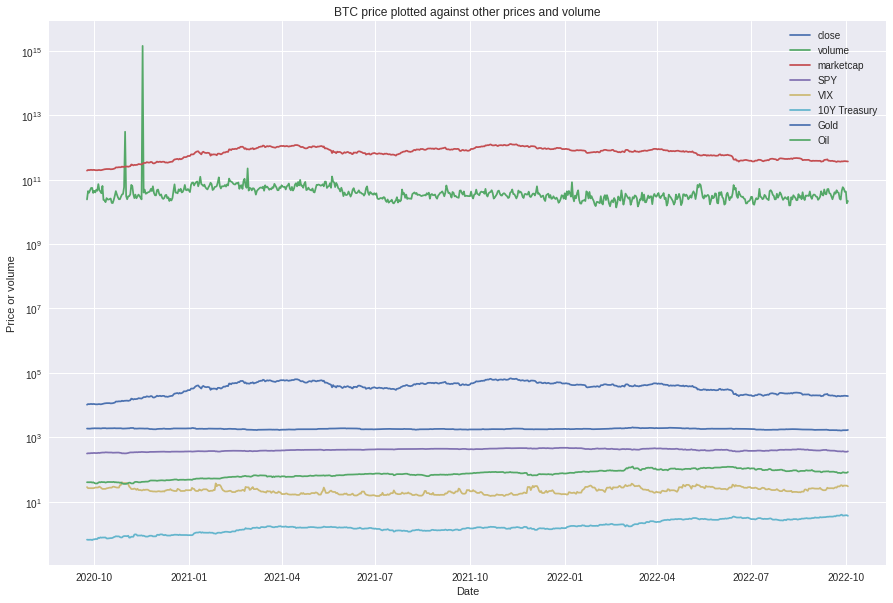

In [22]:
plt.figure(2)
btc.plot(y=['close', 'volume', 'marketcap',
                     'SPY', 'VIX', '10Y Treasury', 'Gold', 'Oil'], logy=True, figsize=(15, 10))
plt.xlabel('Date')
plt.ylabel('Price or volume')
plt.title('BTC price plotted against other prices and volume')
plt.show()

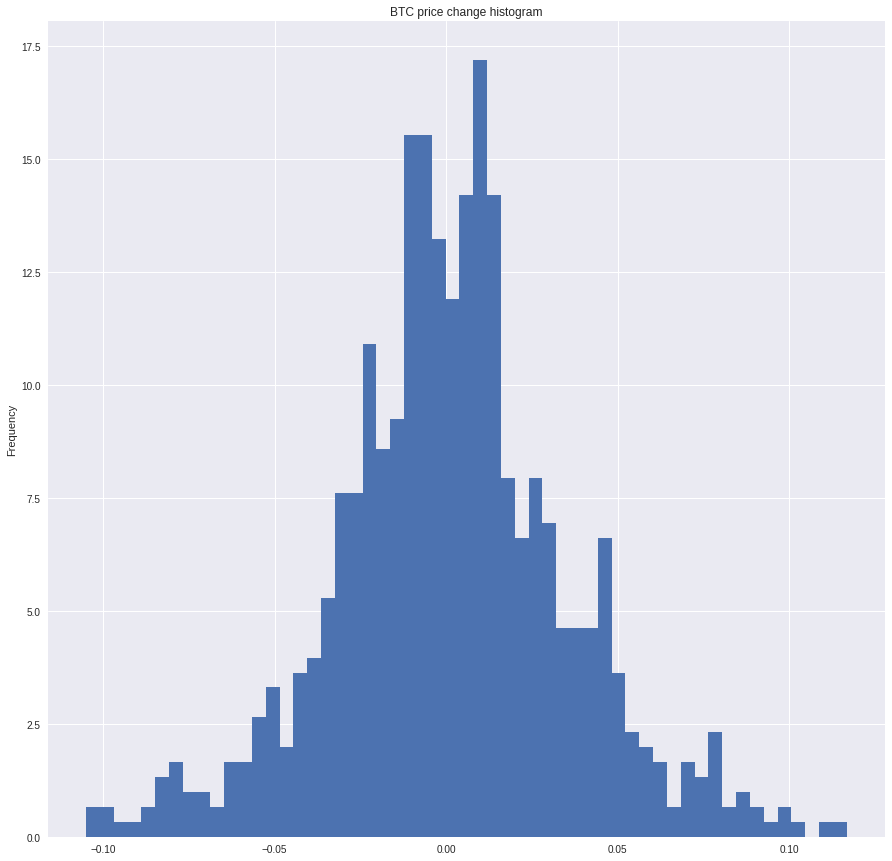

In [23]:
plt.figure(3)
q3, q1 = btc['tomorrow change'].quantile([0.99, 0.01])
btc.loc[(btc['tomorrow change'] < q3) & (btc['tomorrow change'] > q1)]['tomorrow change'].plot.hist(density=1,bins=55)
plt.title('BTC price change histogram')
plt.show()

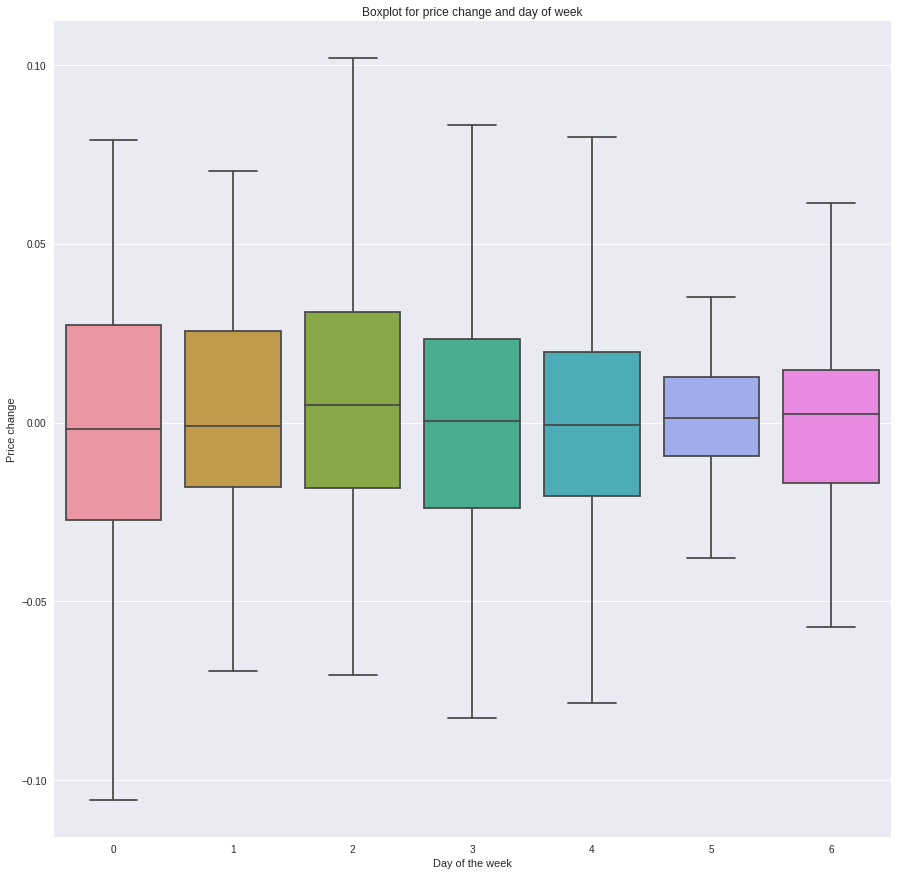

In [24]:
plt.figure(4)
sns.boxplot(y='tomorrow change',x='weekday',data=btc,showfliers=False)
plt.xlabel('Day of the week')
plt.ylabel('Price change')
plt.title('Boxplot for price change and day of week')
plt.show()

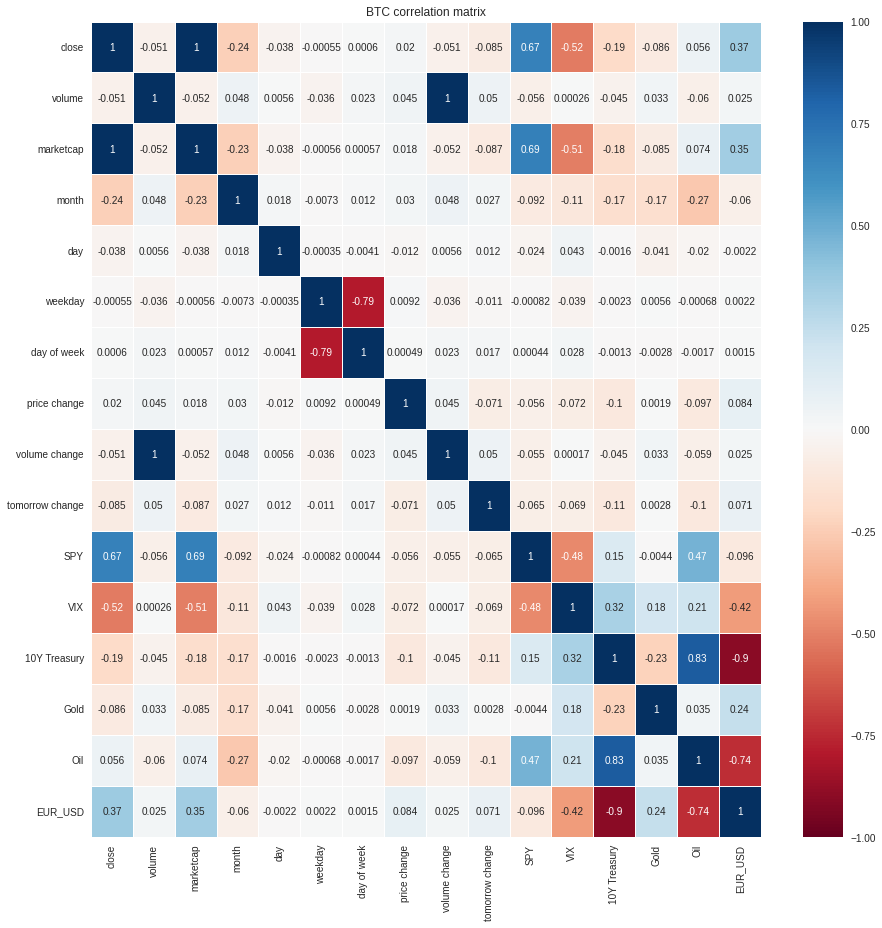

In [25]:
plt.figure(5)
corrmat = btc.corr()
sns.heatmap(corrmat,cmap="RdBu",linewidths=.5, vmin=-1, vmax=1, annot=True)
plt.title('BTC correlation matrix')
plt.show()

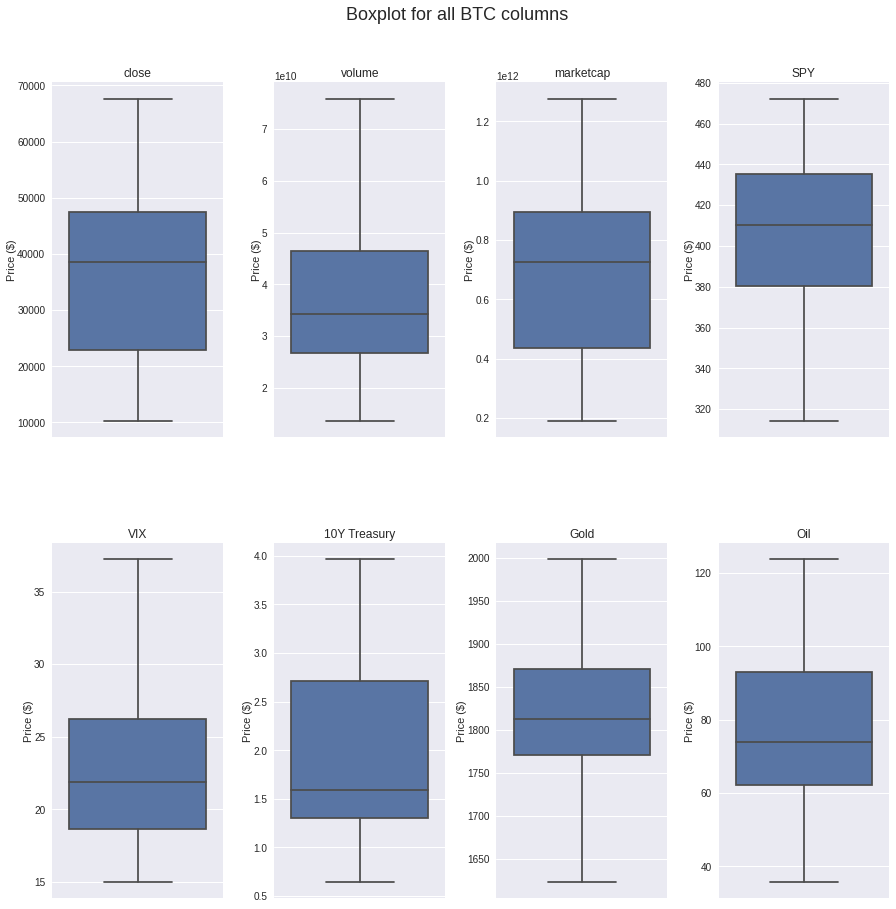

In [30]:
plt.figure(6)
non_day_columns = ['close', 'volume', 'marketcap','SPY', 'VIX', '10Y Treasury', 'Gold', 'Oil']
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
plt.suptitle("Boxplot for all BTC columns", fontsize=18, y = 0.95)
for n, column in enumerate(non_day_columns):
    ax = plt.subplot(2,4, n + 1)
    sns.boxplot(y=btc[column], showfliers=False)
    ax.set_title(column)
    ax.set_ylabel("Price ($)", labelpad = 0.02)